In [1]:
library('tidyverse')
library('tidymodels')

theme_set(theme_gray(base_size = 16))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
data_url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-11-23/episodes.csv"

dr_who_raw = read_csv(data_url, col_types = cols())

dr_who_raw |> head()


era,season_number,serial_title,story_number,episode_number,episode_title,type,first_aired,production_code,uk_viewers,rating,duration
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>
revived,1,NA,157,1,Rose,episode,2005-03-26,1.1,10.81,76,45
revived,1,NA,158,2,The End of the World,episode,2005-04-02,1.2,7.97,76,44
revived,1,NA,159,3,The Unquiet Dead,episode,2005-04-09,1.3,8.86,80,44
revived,1,NA,160a,4,Aliens of London,episode,2005-04-16,1.4,7.63,82,45
revived,1,NA,160b,5,World War Three,episode,2005-04-23,1.5,7.98,81,42
revived,1,NA,161,6,Dalek,episode,2005-04-30,1.6,8.63,84,45


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5 rows containing non-finite values (`stat_bin()`).”


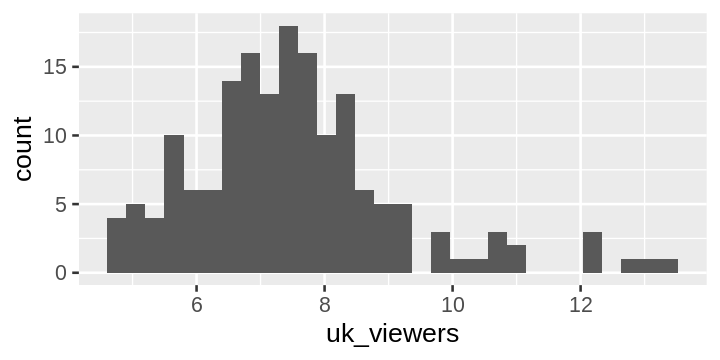

In [3]:
options(repr.plot.height = 3, repr.plot.width = 6)

ggplot(dr_who_raw, aes(x = uk_viewers)) + geom_histogram()

Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”


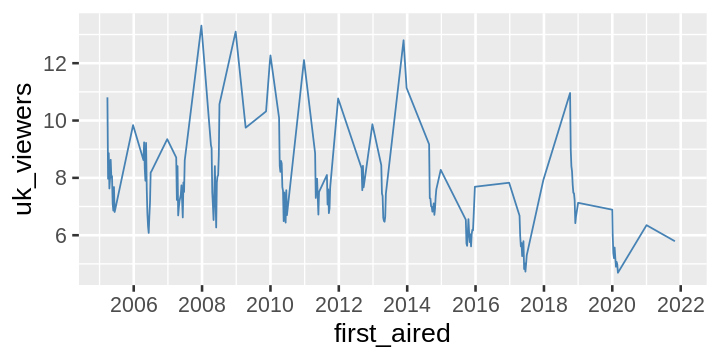

In [4]:
ggplot(dr_who_raw, aes(x = first_aired, y = uk_viewers)) + 
    geom_line(color = 'steelblue') +
    scale_x_date(date_breaks = "2 years", date_labels = "%Y")

In [5]:
dr_who_raw |>
    top_n(uk_viewers, n = 10) |>
    select(first_aired, episode_title)

first_aired,episode_title
<date>,<chr>
2005-03-26,Rose
2007-12-25,Voyage of the Damned
2008-12-25,The Next Doctor
2009-12-25,The End of Time – Part One
2010-01-01,The End of Time – Part Two
2010-12-25,A Christmas Carol
2011-12-25,"The Doctor, the Widow and the Wardrobe"
2013-11-23,The Day of the Doctor
2013-12-25,The Time of the Doctor


In [6]:
rec = recipe(uk_viewers ~ first_aired, data = dr_who_raw) |>
    step_naomit(uk_viewers) |>
    step_date(first_aired, features = 'year') |>
    step_holiday(first_aired, holidays = c('NewYearsDay', 'ChristmasDay'), keep_original_cols = FALSE) |>
    prep()
    
rec |> bake(new_data = NULL) |> glimpse()

Rows: 167
Columns: 4
$ uk_viewers               <dbl> 10.81, 7.97, 8.86, 7.63, 7.98, 8.63, 8.01, 8.…
$ first_aired_year         <int> 2005, 2005, 2005, 2005, 2005, 2005, 2005, 200…
$ first_aired_NewYearsDay  <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ first_aired_ChristmasDay <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, …


In [7]:
mod = linear_reg() |> set_engine('lm')

In [9]:
wf = workflow() |>
    add_recipe(rec) |>
    add_model(mod)

In [11]:
boots = bootstraps(dr_who_raw, times = 1000)

boots |> glimpse()

Rows: 1,000
Columns: 2
$ splits <list> [<boot_split[172 x 59 x 172 x 12]>], [<boot_split[172 x 65 x 1…
$ id     <chr> "Bootstrap0001", "Bootstrap0002", "Bootstrap0003", "Bootstrap00…


In [13]:
fit_mod_on_bootstrap = function(split, wf) {
    mod_fit = wf |> 
        fit(data = as.data.frame(split)) |>
        extract_fit_engine()
    return(mod_fit)
}

In [14]:
boot_models = boots |> 
  mutate(model = map(splits, fit_mod_on_bootstrap, wf = wf),
         coef_info = map(model, tidy))

boot_models |> glimpse()

Rows: 1,000
Columns: 4
$ splits    <list> [<boot_split[172 x 59 x 172 x 12]>], [<boot_split[172 x 65 …
$ id        <chr> "Bootstrap0001", "Bootstrap0002", "Bootstrap0003", "Bootstra…
$ model     <list> [258.6283438, -0.1249568, 0.6280922, 2.8875735, -1.31566860…
$ coef_info <list> [<tbl_df[4 x 5]>], [<tbl_df[4 x 5]>], [<tbl_df[4 x 5]>], [<…


In [15]:
percentile_intervals = int_pctl(boot_models, coef_info)
percentile_intervals

Warning message:
“Recommend at least 1000 non-missing bootstrap resamples for term `first_aired_NewYearsDay`.”


term,.lower,.estimate,.upper,.alpha,.method
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),233.4025908,327.2591419,409.9810437,0.05,percentile
first_aired_ChristmasDay,1.9628715,2.8912154,3.8710786,0.05,percentile
first_aired_NewYearsDay,0.3915991,1.7890119,4.5376320,0.05,percentile
first_aired_year,-0.2001918,-0.1590706,-0.1124444,0.05,percentile


In [16]:
boot_coefs = boot_models |>
    select(coef_info) |>
    unnest(coef_info)

In [18]:
boot_coefs |> glimpse()

Rows: 4,000
Columns: 5
$ term      <chr> "(Intercept)", "first_aired_year", "first_aired_NewYearsDay"…
$ estimate  <dbl> 258.6283438, -0.1249568, 0.6280922, 2.8875735, 412.2605288, …
$ std.error <dbl> 43.22803803, 0.02149067, 0.67503309, 0.33939288, 42.21167255…
$ statistic <dbl> 5.9828842, -5.8144659, 0.9304614, 8.5080556, 9.7665054, -9.5…
$ p.value   <dbl> 1.308994e-08, 3.042585e-08, 3.534834e-01, 9.972837e-15, 5.79…


Warning message:
“Removed 29 rows containing non-finite values (`stat_bin()`).”


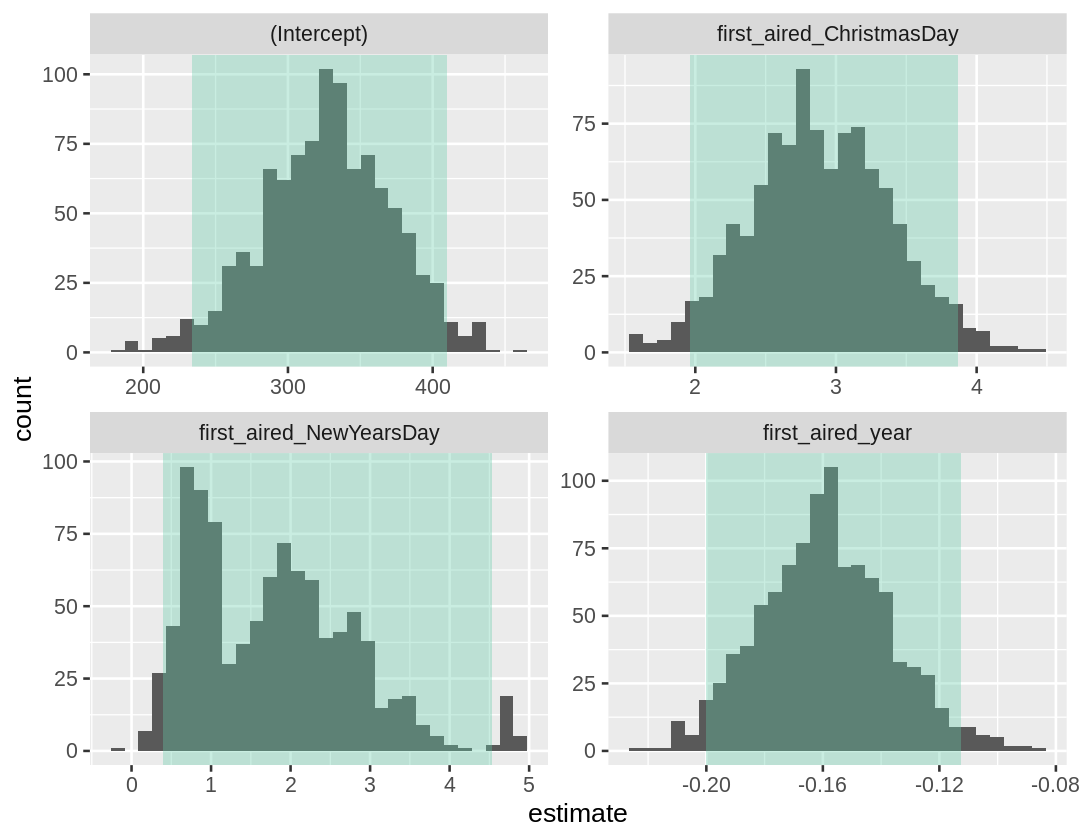

In [19]:
options(repr.plot.height = 7, repr.plot.width = 9)

ggplot(boot_coefs) +
    geom_histogram(bins = 30, data = boot_coefs, mapping = aes(x = estimate)) +
    facet_wrap( ~ term, scales = "free", ncol = 2) +
    geom_rect(data = percentile_intervals, 
              mapping = aes(xmin = .lower, xmax = .upper, ymin = -Inf, ymax = Inf),
              alpha = 0.35, fill = 'MediumAquaMarine')

This is based on a fantastic demo from [Julia Silge's blog](https://juliasilge.com/blog/doctor-who/).